This notebook approximates neural networks to simulated data

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import quad


c:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Geometric Brownian Motion (Black Scholes)

In [2]:
def black_scholes(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return price

## Generating options data

In [45]:


def simulate_gbm(S0, mu, sigma, T, dt, steps):
    np.random.seed(42)  # For reproducibility
    t = np.linspace(0, T, steps)
    W = np.random.standard_normal(size=steps)
    W = np.cumsum(W) * np.sqrt(dt)
    X = (mu - 0.5 * sigma ** 2) * t + sigma * W
    return S0 * np.exp(X)

# Parameters for stock price simulation
S0 = 100  # Initial stock price
mu = 0.1  # Drift (10% annual return)
sigma = 0.2  # Volatility (20%)
T = 2  # Time in years (2 years)
steps = 504  # Two years of daily prices (252 trading days per year)
dt = T / steps  # Time step (1/252)
r = 0.02 # Risk-free rate

# Simulate the stock price
stock_prices = simulate_gbm(S0, mu, sigma, T, dt, steps)




def generate_option_chain(stock_price, step, strikes_interval=5, expiry_intervals=np.array([30, 60, 90, 120])):
    # Generate strike prices around the current stock price
    strikes = np.arange(stock_price - 30, stock_price + 30, strikes_interval)
    
    # Generate option expirations (in days to expiration)
    expiries = [step + exp_days for exp_days in expiry_intervals]
    
    # Combine all options
    option_chain = [{"strike": strike, "expiry": expiry} for strike in strikes for expiry in expiries]
    
    return option_chain

# Example of generating option chain for a particular day
# current_stock_price = stock_prices[0]
# option_chain = generate_option_chain(current_stock_price, 0)



# Price options in the generated chain
# option_prices = []
# for option in option_chain:
#    strike = option['strike']
#    expiry = option['expiry']
#    T_expiry = expiry / 252  # Convert days to years
#    price = black_scholes(current_stock_price, strike, T_expiry, r, volatility)
#    option_prices.append({'strike': strike, 'expiry': expiry, 'price': price})



option_data = []
for step, stock_price in enumerate(stock_prices):
    option_chain = generate_option_chain(stock_price, step)
    for option in option_chain:
        strike = option['strike']
        expiry = option['expiry']
        T_expiry = (expiry - step) / 252  # Days to expiration
        price = black_scholes(stock_price, strike, T_expiry, r, sigma)
        option_data.append({
            'step': step,
            'stock_price': stock_price,
            'strike': strike,
            'expiry': expiry,
            'price': price
        })

option_data = pd.DataFrame(option_data)



## Ploting

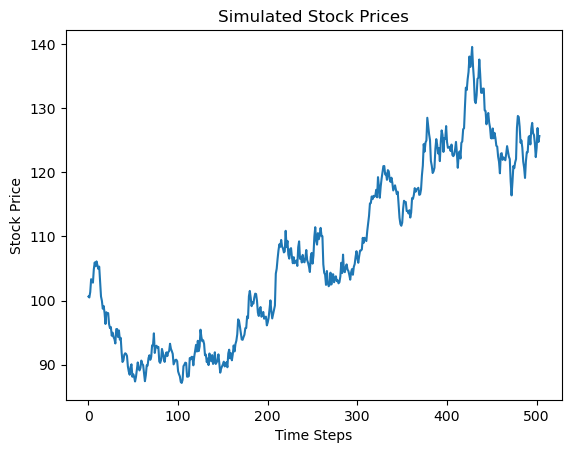

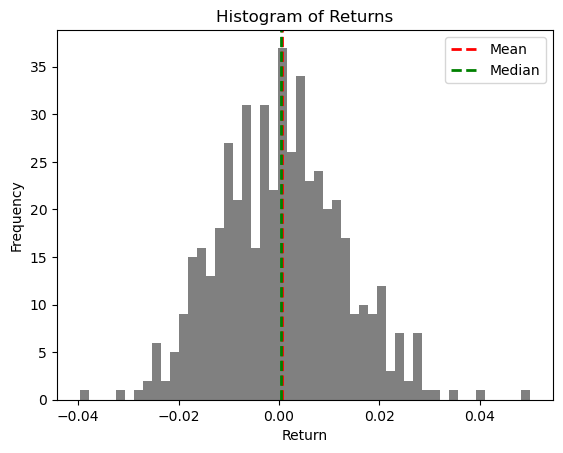

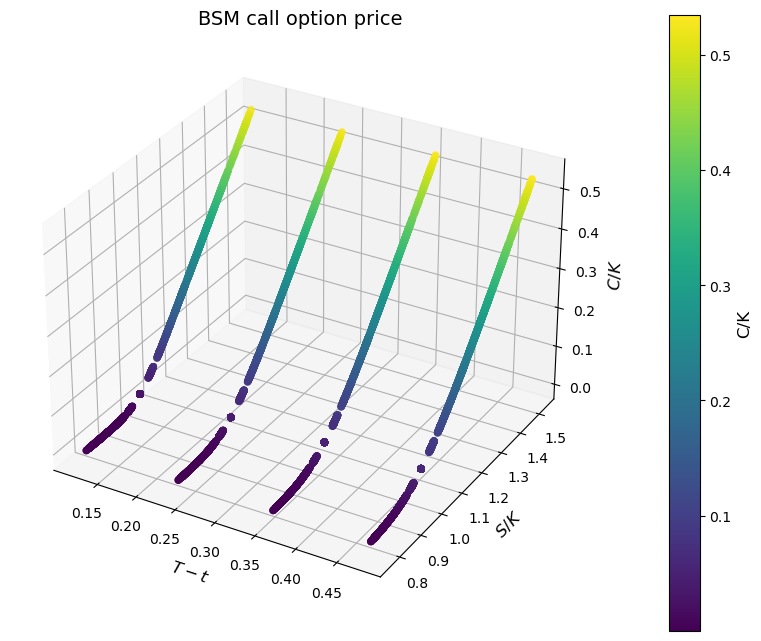

In [4]:

# plot simulated stock prices
plt.plot(stock_prices)
plt.title("Simulated Stock Prices")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.show()

# plot histogram of returns of the simulated stock prices
returns = np.diff(stock_prices) / stock_prices[:-1]
plt.axvline(returns.mean(), color='red', linestyle='dashed', linewidth=2)
plt.axvline(np.median(returns) , color='green', linestyle='dashed', linewidth=2)
plt.hist(returns, bins=50, color='grey')
plt.title("Histogram of Returns")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.legend(["Mean", "Median"])
plt.show()

# calculate monneyness
option_data['monneyness'] = option_data['price'] / option_data['strike']

# calculate time to maturity
option_data['time_to_maturity'] = (option_data['expiry'] - option_data['step'])/252

# calculate stock price/strike ratio
option_data['stock_strike_ratio'] = option_data['stock_price'] / option_data['strike']


# Sort values consistently
option_data = option_data.sort_values(by=['time_to_maturity', 'stock_strike_ratio'])

# Plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
sc = ax.scatter(option_data['time_to_maturity'], 
                option_data['stock_strike_ratio'], 
                option_data['monneyness'], 
                c=option_data['monneyness'])

# Adding labels
ax.set_xlabel('$T-t$', fontsize=12)
ax.set_ylabel('$S/K$', fontsize=12)
ax.set_zlabel('$C/K$', fontsize=12)
ax.set_title("BSM call option price", fontsize=14)

# Customize the view angle for better visualization (optional)
#ax.view_init(elev=30, azim=120)

# Adding a color bar (optional, helps in visualizing intensity of monneyness)
cbar = plt.colorbar(sc, pad=0.1)
cbar.set_label('C/K', fontsize=12)

# Show plot
plt.show()







# Heston Model

In [4]:
def heston_model_sim(S0, v0, rho, kappa, theta, sigma,T, N, M):
    """
    Inputs:
     - S0, v0: initial parameters for asset and variance
     - rho   : correlation between asset returns and variance
     - kappa : rate of mean reversion in variance process
     - theta : long-term mean of variance process
     - sigma : vol of vol / volatility of variance process
     - T     : time of simulation
     - N     : number of time steps
     - M     : number of scenarios / simulations

    Outputs:
    - asset prices over time (numpy array)
    - variance over time (numpy array)
    """
    # initialise other parameters
    dt = T/N
    mu = np.array([0,0])
    cov = np.array([[1,rho],
                    [rho,1]])

    # arrays for storing prices and variances
    S = np.full(shape=(N+1,M), fill_value=S0)
    v = np.full(shape=(N+1,M), fill_value=v0)

    # sampling correlated brownian motions under risk-neutral measure
    Z = np.random.multivariate_normal(mu, cov, (N,M))

    for i in range(1,N+1):
        S[i] = S[i-1] * np.exp( (r - 0.5*v[i-1])*dt + np.sqrt(v[i-1] * dt) * Z[i-1,:,0] )
        v[i] = np.maximum(v[i-1] + kappa*(theta-v[i-1])*dt + sigma*np.sqrt(v[i-1]*dt)*Z[i-1,:,1],0)

    return S, v

In [54]:
# Parameters
# simulation dependent
S0 = 100.0             # asset price
T = 1.0                # time in years
r = 0.02               # risk-free rate
N = 252                # number of time steps in simulation
M = 1               # number of simulations

# Heston dependent parameters
kappa = 3              # rate of mean reversion of variance under risk-neutral dynamics
theta = 0.20**2        # long-term mean of variance under risk-neutral dynamics
v0 = 0.25**2           # initial variance under risk-neutral dynamics
rho = 0.4              # correlation between returns and variances under risk-neutral dynamics
sigma = 0.6            # volatility of volatility

S_t, v_t = heston_model_sim(S0, v0, rho, kappa, theta, sigma, T, N, M)



Text(0, 0.5, 'Variance')

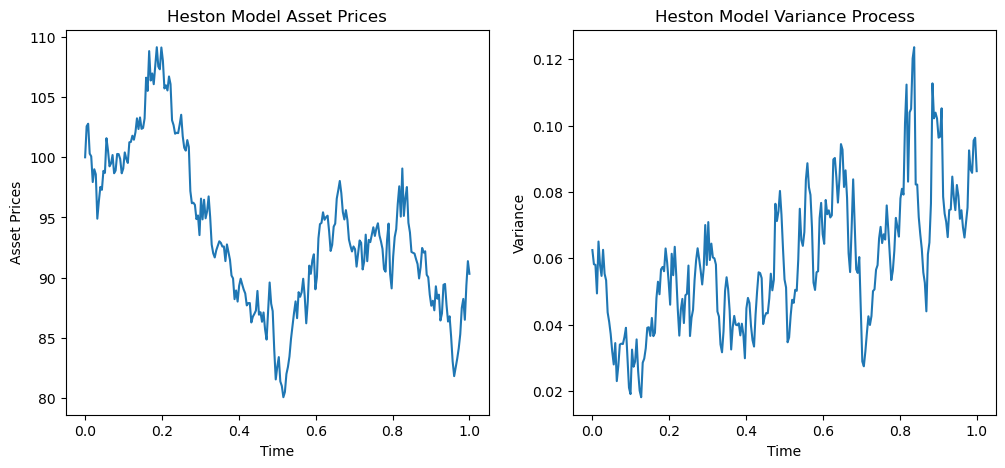

In [55]:
fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(12,5))
time = np.linspace(0,T,N+1)
ax1.plot(time,S_t)
ax1.set_title('Heston Model Asset Prices')
ax1.set_xlabel('Time')
ax1.set_ylabel('Asset Prices')

ax2.plot(time,v_t)
ax2.set_title('Heston Model Variance Process')
ax2.set_xlabel('Time')
ax2.set_ylabel('Variance')






In [50]:


plt.axvline(returns.mean(), color='red', linestyle='dashed', linewidth=2)
plt.axvline(np.median(returns) , color='green', linestyle='dashed', linewidth=2)
plt.hist(returns, bins=50, color='grey')
plt.title("Histogram of Returns")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.legend(["Mean", "Median"])
plt.show()

ValueError: diff requires input that is at least one dimensional

## Part 1 - implementing the characteristic function



$$
\varphi (X_0, K, v_0, \tau, \phi) = e^{r \phi i \tau} S^{i \phi} \left[ \frac{1 - g e^{d \tau}}{1 - g} \right]^{\frac{-2a}{\sigma^2}} \exp \left[ \frac{a \tau}{\sigma^2} \left( b_2 - \rho \sigma \phi i + d \right) + \frac{v_0}{\sigma^2} (b_2 - \rho \sigma \phi i + d) \left[ \frac{1 - e^{d \tau}}{1 - g e^{d \tau}} \right] \right]
$$
where $ d $ and $ g $ no longer change with $ b_1 $, $ b_2 $, or $ u_1 $, $ u_2 $.

$$
d = \sqrt{(\rho \sigma \phi i - b)^2 + \sigma^2 (\phi i + \phi^2)}
$$
$$
g = \frac{b - \rho \sigma \phi i + d}{b - \rho \sigma \phi i - d}
$$
$$
a = \kappa \theta
$$
$$
b = \kappa + \lambda
$$


In [7]:
def heston_charfunc(phi, S0, v0, kappa, theta, sigma, rho, lambd, tau, r):

    # constants
    a = kappa*theta
    b = kappa+lambd

    # common terms w.r.t phi
    rspi = rho*sigma*phi*1j

    # define d parameter given phi and b
    d = np.sqrt( (rho*sigma*phi*1j - b)**2 + (phi*1j+phi**2)*sigma**2 )

    # define g parameter given phi, b and d
    g = (b-rspi+d)/(b-rspi-d)

    # calculate characteristic function by components
    exp1 = np.exp(r*phi*1j*tau)
    term2 = S0**(phi*1j) * ( (1-g*np.exp(d*tau))/(1-g) )**(-2*a/sigma**2)
    exp2 = np.exp(a*tau*(b-rspi+d)/sigma**2 + v0*(b-rspi+d)*( (1-np.exp(d*tau))/(1-g*np.exp(d*tau)) )/sigma**2)

    return exp1*term2*exp2

## Part 2 - define the integrand as a function

$$\int_0^{\infty} \mathfrak{R} \left[ e^{r \tau} \frac{\varphi(\phi - i)}{i \phi K^{i \phi}} - K \frac{\varphi(\phi)}{i \phi K^{i \phi}} \right] d\phi$$

In [8]:
def integrand(phi, S0, v0, kappa, theta, sigma, rho, lambd, tau, r):
    args = (S0, v0, kappa, theta, sigma, rho, lambd, tau, r)
    numerator = np.exp(r*tau)*heston_charfunc(phi-1j,*args) - K*heston_charfunc(phi,*args)
    denominator = 1j*phi*K**(1j*phi)
    return numerator/denominator

## Part 3 - perform numerical integration over integrand and calculate option price

$$C(S_0, K, v_0, \tau) = \frac{1}{2} \left( S_0 - K e^{-r \tau} \right) + \frac{1}{\pi} \int_0^{\infty} \mathfrak{R} \left[ e^{r \tau} \frac{\varphi(\phi - i)}{i \phi K^{i \phi}} - K \frac{\varphi(\phi)}{i \phi K^{i \phi}} \right] d\phi$$

In [9]:
def heston_price(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r):
    args = (S0, v0, kappa, theta, sigma, rho, lambd, tau, r)

    real_integral, err = np.real( quad(integrand, 0, 100, args=args) )

    return (S0 - K*np.exp(-r*tau))/2 + real_integral/np.pi

In [32]:

# Parameters
S0 = 100            # stock price
v0 = 0.04              # initial variance
mu = 0.1               # drift
sigma = 0.2            # volatility
r = 0.02               # risk-free rate
rho = 0.4              # correlation between variance and stock process
kappa = 0.2            # rate of mean reversion of variance process
theta = 0.05           # long-term mean of variance process
lambda_ = 0.2          # risk premium of variance process

K = 125
tau = 120/252

heston_price(S0, K, v0, kappa, theta, sigma, rho, lambda_, tau, r)


c:\ProgramData\anaconda3\Lib\site-packages\scipy\integrate\_quadpack_py.py:575: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


0.2987190487183131

## Simulating option prices under the Heston model

In [26]:
T = 2 
N = 252*2
M = 1

stock_prices, variances = heston_model_sim(S0, v0, rho, kappa, theta, sigma, T, N, M)




In [27]:


option_data = []
for step, (stock_price, variance) in enumerate(zip(stock_prices[0], variances[0])):
    option_chain = generate_option_chain(stock_price, step)
    
    for option in option_chain:
        strike = option['strike']
        expiry = option['expiry']
        T_expiry = (expiry - step) / 252  # Days to expiration in years
        
        
        price = heston_price(stock_price, strike, variance, kappa, theta, sigma, rho, lambda_, T_expiry, r)
        
        # Store the option data
        option_data.append({
            'step': step,
            'stock_price': stock_price,
            'strike': strike,
            'expiry': expiry,
            'price': price
        })

option_data = pd.DataFrame(option_data)

c:\ProgramData\anaconda3\Lib\site-packages\scipy\integrate\_quadpack_py.py:575: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)
